In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 64
learning_rate = 0.001
num_epochs = 5

In [5]:
transform = transforms.Compose([
    #transforms.Resize((28,28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

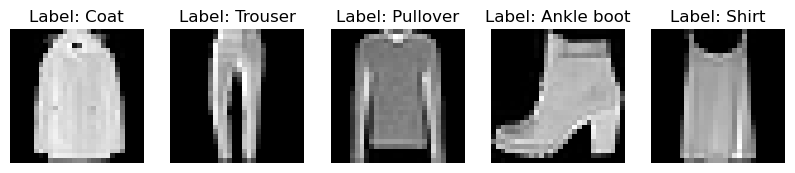

In [25]:
class_names = train_dataset.classes
sample_batch, sample_labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {class_names[sample_labels[i]]}")
    plt.axis('off')
plt.show()

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Output values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [17]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/5], Step [100/938], Loss: 0.6095
Epoch [1/5], Step [200/938], Loss: 0.6072
Epoch [1/5], Step [300/938], Loss: 0.5607
Epoch [1/5], Step [400/938], Loss: 0.6237
Epoch [1/5], Step [500/938], Loss: 0.6014
Epoch [1/5], Step [600/938], Loss: 0.5956
Epoch [1/5], Step [700/938], Loss: 0.5836
Epoch [1/5], Step [800/938], Loss: 0.5987
Epoch [1/5], Step [900/938], Loss: 0.5880
Epoch [2/5], Step [100/938], Loss: 0.6042
Epoch [2/5], Step [200/938], Loss: 0.5942
Epoch [2/5], Step [300/938], Loss: 0.6349
Epoch [2/5], Step [400/938], Loss: 0.6061
Epoch [2/5], Step [500/938], Loss: 0.5959
Epoch [2/5], Step [600/938], Loss: 0.5753
Epoch [2/5], Step [700/938], Loss: 0.5813
Epoch [2/5], Step [800/938], Loss: 0.5951
Epoch [2/5], Step [900/938], Loss: 0.6010
Epoch [3/5], Step [100/938], Loss: 0.6114
Epoch [3/5], Step [200/938], Loss: 0.6071
Epoch [3/5], Step [300/938], Loss: 0.6088
Epoch [3/5], Step [400/938], Loss: 0.6283
Epoch [3/5], Step [500/938], Loss: 0.5970
Epoch [3/5], Step [600/938], Loss:

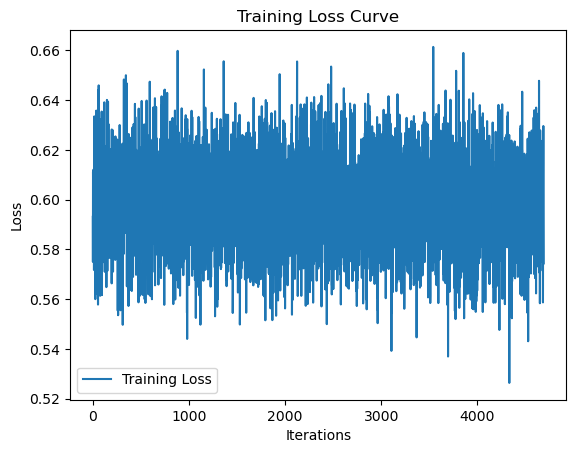

In [23]:
train_losses = []
for epoch in range(num_epochs):
    for batch_idx, (images, _) in enumerate(train_loader):
        # Flatten the images
        images = images.view(images.size(0), -1).to(device)

        # Mask input images
        mask = torch.rand_like(images) > 0.5  # Randomly mask half of the pixels
        masked_images = images.clone()
        masked_images[mask] = 0

        # Forward pass
        outputs = model(masked_images)

        # Compute the loss
        loss = criterion(outputs, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Print loss
        if (batch_idx+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, batch_idx+1, len(train_loader), loss.item()))

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [19]:
def visualize(original, masked, reconstructed):
    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20, 6))
    for images, row in zip([original, masked, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.show()

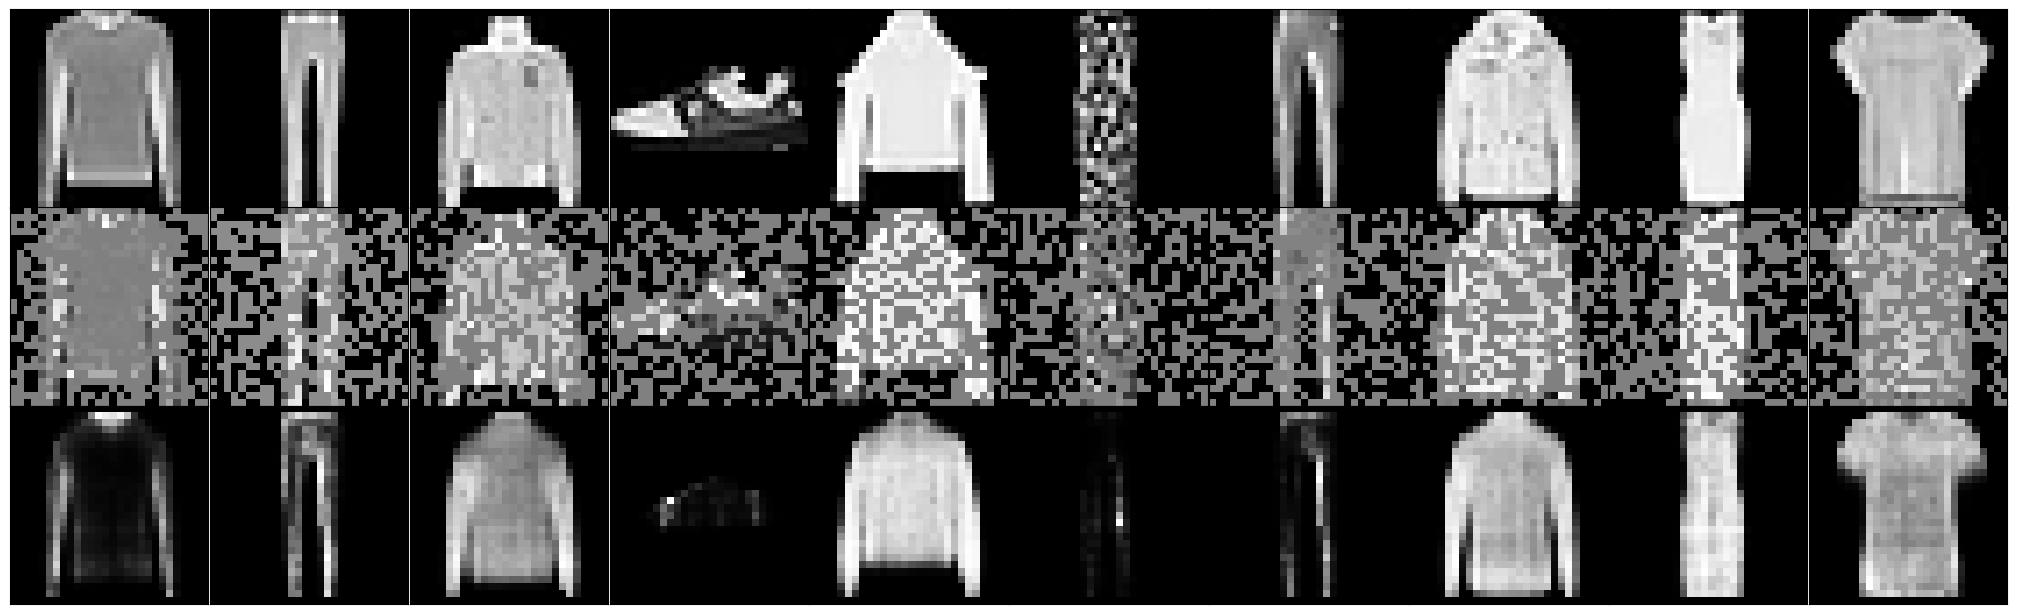

In [20]:
sample_original, _ = next(iter(train_loader))
sample_masked = sample_original.clone()
mask = torch.rand_like(sample_masked) > 0.5 
sample_masked[mask] = 0
sample_reconstructed = model(sample_masked.view(sample_masked.size(0), -1).to(device)).cpu().detach()
visualize(sample_original[:10], sample_masked[:10], sample_reconstructed[:10])